## 랜덤 포레스트

### 랜덤 포레스트의 개요 및 실습
- 랜덤 포레스트의 기반 알고리즘은 결정 트리로서 결정 트리의 쉽고 직관적인 장점을 그대로 가지고 있다.
- 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트이다. 이렇게 여러 개의 데이터 세트를 중첩되게 분리하는 것을 부트스트래핑 분할 방식이라고 한다.
- 랜덤 포레스트의 서브세트 데이터는 이러한 부트스트래핑으로 데이터가 임의로 만들어진다.
- 3개의 결정 트리 기반으로 학습하려고 n_estimators=3으로 하이퍼 파라미터를 부여한다.

In [5]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)

    return new_feature_name_df

In [6]:
import pandas as pd 

def get_human_dataset():
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('../data/human_activity/features.txt', sep='\s+', header=None, names=['column_index' ,'column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    x_train = pd.read_csv('../data/human_activity/train/X_train.txt',sep='\s+', names=feature_name)
    x_test = pd.read_csv('../data/human_activity/test/X_test.txt', sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('../data/human_activity/train/y_train.txt', sep='\s+', header=None,names=['action'])
    y_test = pd.read_csv('../data/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_human_dataset()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()를 이용해 학습/테스트용 DataFrame 반환
x_train, x_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(x_train,y_train)
pred = rf_clf.predict(x_test)
accuracy = accuracy_score(y_test,pred)
print('래덤 포레스트 정확도: {0:.4f}'.format(accuracy))

래덤 포레스트 정확도: 0.9253


In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_cf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(x_train,y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도:0.9180


In [11]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, min_samples_split=8, random_state=0)
rf_clf1.fit(x_train,y_train)
pred = rf_clf1.predict(x_test)
print('예측 정확도:{0:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도:0.9165


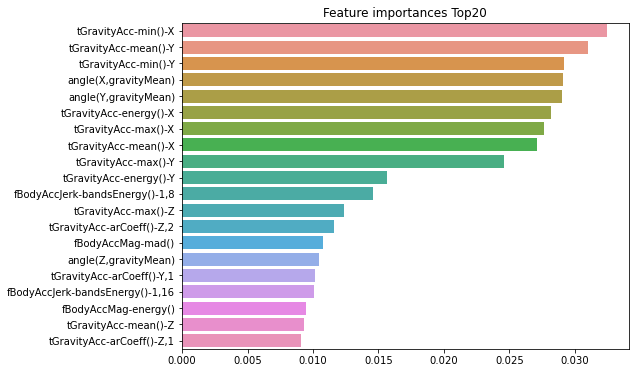

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()